In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import pandas as pd
from pathlib import Path
from PIL import Image
import cv2
import time
import os
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [5]:
train_data = image_dataset_from_directory(
    directory='/media/raghav/faces_data/',
    labels='inferred',
    label_mode='categorical',
    subset="training",
    validation_split = 0.1,
    seed=123,
    batch_size=64,
    image_size=(128, 128))

Found 139572 files belonging to 1225 classes.
Using 125615 files for training.


2021-11-13 11:57:58.491714: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-13 11:57:59.347348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 27163 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:17:00.0, compute capability: 7.0
2021-11-13 11:57:59.348475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 26803 MB memory:  -> device: 1, name: Quadro GV100, pci bus id: 0000:65:00.0, compute capability: 7.0


In [6]:
validation_data = image_dataset_from_directory(
    directory='/media/raghav/faces_data/',
    labels='inferred',
    label_mode='categorical',
    subset="validation",
    validation_split = 0.1,
    seed=123,
    batch_size=64,
    image_size=(128, 128))

Found 139572 files belonging to 1225 classes.
Using 13957 files for validation.


In [2]:
names = []
names_data = []
count = -1
basepath = Path('/media/raghav/faces/')
files_in_basepath = basepath.iterdir()
for item in files_in_basepath:
    name = str(item)
    names.append(name.split('/')[4])
    count = count + 1
    files_in_subdir = item.iterdir()
    for data in files_in_subdir:
        names_data.append(names[count])

In [3]:
print(np.shape(faces_data))
print(np.shape(names_data))

(2681, 128, 128, 3)
(2681,)


Sebastian_Pinera


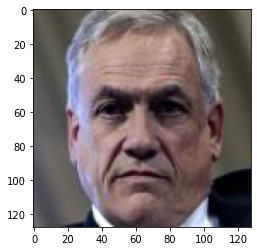

In [4]:
plt.imshow(faces_data[1])
print(names_data[1])

In [5]:
#data_df = pd.DataFrame({'img':faces_data, 'name':names_data})
#data_df.head()

In [6]:
#data_df['img'], data_df['name'] = shuffle(data_df['img'], data_df['name'], random_state = 100)

In [7]:
faces_data = np.array(faces_data)
faces_data = (faces_data - 127.5)/127.5

In [8]:
names_data = np.array(names_data)
enc = OneHotEncoder()
names_data = enc.fit_transform(names_data.reshape(-1, 1)).toarray()

In [9]:
trainX, testX, trainY, testY = train_test_split(faces_data, names_data, test_size=0.1, random_state=1)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.1, random_state=1)

In [10]:
print(np.shape(trainX))
print(np.shape(valX))
print(np.shape(testX))
print(np.shape(trainY))
print(np.shape(valY))
print(np.shape(testY))

(2170, 128, 128, 3)
(242, 128, 128, 3)
(269, 128, 128, 3)
(2170, 25)
(242, 25)
(269, 25)


In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(128,128,3)))
model.add(tf.keras.layers.Rescaling(1./127.5, offset=-1))
model.add(tf.keras.applications.vgg16.VGG16(include_top = False, weights = 'imagenet', pooling = 'max', input_shape= (128,128,3)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1225, activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1225)              628425    
Total params: 15,343,113
Trainable params: 15,343,113
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = 'max', patience = 7)

history = model.fit(train_data, epochs=250, batch_size = 64, validation_data = validation_data, callbacks = [early_stopping], verbose=1)

In [14]:
'''model.save('/home/raghav/Downloads/classifier.h5')'''

"model.save('/home/raghav/Downloads/classifier.h5')"

In [15]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,3.351111,0.069124,2.962057,0.140496
1,2.858324,0.147005,2.688371,0.219008
2,2.671196,0.202765,2.500768,0.256198
3,2.478713,0.241935,2.359038,0.326446
4,2.253172,0.302765,2.172681,0.338843


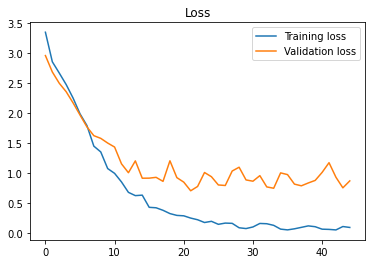

In [16]:
# plotting training and validation loss
plt.title('Loss')
plt.plot(history_df['loss'], label = 'Training loss')
plt.plot(history_df['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

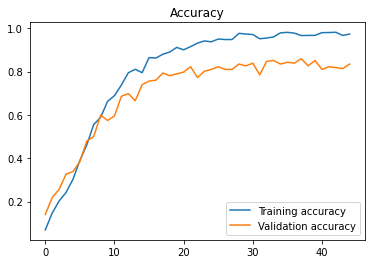

In [17]:
# plotting training and validation accuracy
plt.title('Accuracy')
plt.plot(history_df['accuracy'], label = 'Training accuracy')
plt.plot(history_df['val_accuracy'], label = 'Validation accuracy')
#plt.ylim(0,1)
plt.legend()
plt.show()

In [18]:
'''my_model = tf.keras.models.load_model('/home/raghav/Downloads/classifier.h5')'''

"my_model = tf.keras.models.load_model('/home/raghav/Downloads/classifier.h5')"

In [19]:
predY = model.predict(testX)
predY = np.round(predY, decimals = 0)
accuracy = accuracy_score(testY, predY)
print("Test accuracy - ", (accuracy*100))

Test accuracy -  81.04089219330855
